In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import pandas as pd

import numpy as np
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
import nibabel as nib

from brainiak.isc import isc
from brainiak.fcma.util import compute_correlation
import brainiak.funcalign.srm
from brainiak import image, io

import matplotlib.pyplot as plt

%autosave 5
%matplotlib inline

Autosaving every 5 seconds


In [7]:
#set directories
curr_dir = '/user_data/vayzenbe/GitHub_Repos/ginn'
exp_dir= f'ginn/fmri/hbn'
study_dir = f'/lab_data/behrmannlab/scratch/vlad/{exp_dir}'
subj_dir=f'{study_dir}/derivatives/preprocessed_data'
out_dir = f'{study_dir}/derivatives/mean_func'
results_dir =f'{curr_dir}/results/mvpd'
roi_dir = f'{study_dir}/derivatives/rois'
curr_subs = pd.read_csv(f'{curr_dir}/fmri/HBN-Site-CBIC.csv')
age = 18

raider_data_dir = f'{curr_dir}/fmri/raider'

In [9]:
# Load data
movie_data = np.load(os.path.join(raider_data_dir, 'movie.npy'))

# Pull out the shape data
vox_num, nTR, num_subs = movie_data.shape  

print('Participants ', num_subs)
print('Voxels per participant ', vox_num)
print('TRs per participant ', nTR)

Participants  10
Voxels per participant  1000
TRs per participant  2203


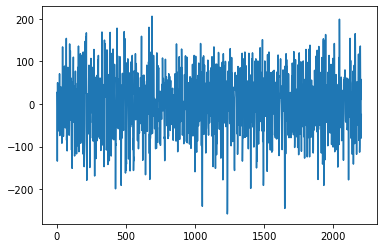

In [45]:
plt.plot(movie_data[0,:,0])

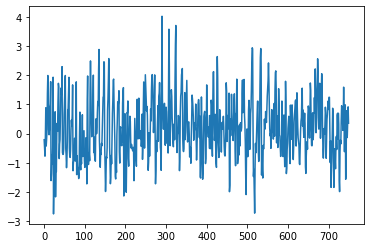

In [49]:
plt.plot(all_data[0,:,0])

In [20]:
train_data = []
test_data = []
for sub in range(num_subs):
    # Take the first half of TRs as training
    # *The double dash means integer division
    train_data.append(movie_data[:, :nTR//2, sub])
    
    # Take the second half of TRs as testing
    test_data.append(movie_data[:, -(nTR//2):, sub])  

# Iterate through the subjects
for sub in range(num_subs):    
    
    # Do it for training data
    train_data[sub] = stats.zscore(train_data[sub], axis=1, ddof=1)
    train_data[sub] = np.nan_to_num(train_data[sub])
    
    # Do it for test data
    test_data[sub] = stats.zscore(test_data[sub], axis=1, ddof=1)
    test_data[sub] = np.nan_to_num(test_data[sub])

In [58]:
features = 50  # How many features will you fit?
n_iter = 20  # How many iterations of fitting will you perform

# Create the SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)

# Fit the SRM data
print('Fitting SRM, may take a minute ...')
srm.fit(train_data)

print('SRM has been fit')

Fitting SRM, may take a minute ...
SRM has been fit


In [17]:
def get_existing_files(curr_subs):
    
    sub_file =pd.DataFrame(columns=['sub','age'])
    for sub in enumerate(curr_subs['participant_id']):
        img = f'{subj_dir}/sub-{sub[1]}/sub-{sub[1]}_task-movieDM_bold.nii.gz'
        
        if os.path.exists(img):
            
            sub_file = sub_file.append(pd.Series([sub[1], curr_subs['Age'][sub[0]]], index = sub_file.columns), ignore_index = True)

    return sub_file

curr_subs = get_existing_files(curr_subs)
curr_subs = curr_subs[curr_subs['age']>=18]
curr_sub = curr_subs.reset_index()

In [46]:
'''
load subs into numpy array
'''
lr ='r'
roi = 'LO'

n = 0
for sub in curr_subs['sub']:
    
    sub_ts = np.load(f'{subj_dir}/sub-{sub}/timeseries/{lr}{roi}_ts_all.npy')
    sub_ts = np.expand_dims(sub_ts,axis =2)
    sub_ts = np.reshape(sub_ts, [sub_ts.shape[1], sub_ts.shape[0], sub_ts.shape[2]])
    
    if n == 0:
        all_data = sub_ts
        
        n += 1
    else:
        try:
            all_data = np.concatenate((all_data,sub_ts), axis = 2)
        except:
            continue
        
    

In [50]:
train_data = []
test_data = []
for sub in range(0,all_data.shape[2]):
    # Take the first half of TRs as training
    # *The double dash means integer division
    train_data.append(all_data[:, :all_data.shape[1]//2, sub])
    
    # Take the second half of TRs as testing
    test_data.append(all_data[:, -(all_data.shape[1]//2):, sub])  

In [57]:
# Iterate through the subjects
for sub in range(0,all_data.shape[2]):    
    
    # Do it for training data
    train_data[sub] = stats.zscore(train_data[sub], axis=1, ddof=1)
    train_data[sub] = np.nan_to_num(train_data[sub])
    
    # Do it for test data
    test_data[sub] = stats.zscore(test_data[sub], axis=1, ddof=1)
    test_data[sub] = np.nan_to_num(test_data[sub])

In [130]:
np.mean(train_data[0])

9.624947e-05

SRM: Features X Time-points  (50, 375)


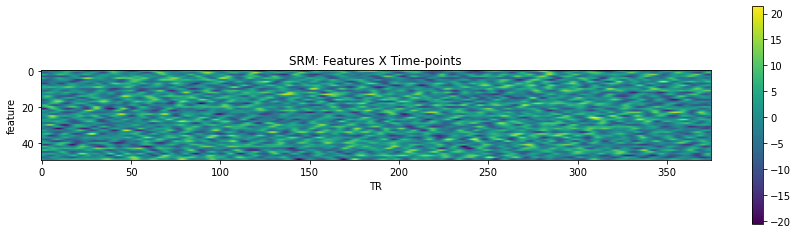

In [59]:
# Plot the shared response
print('SRM: Features X Time-points ', srm.s_.shape)
plt.figure(figsize=(15, 4))
plt.title('SRM: Features X Time-points')
plt.xlabel('TR')
plt.ylabel('feature')
plt.imshow(srm.s_, cmap='viridis')
plt.colorbar()

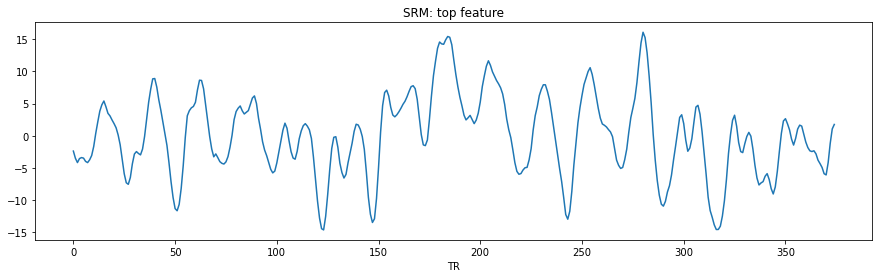

In [60]:
plt.figure(figsize=(15, 4)
)
plt.title('SRM: top feature')
plt.xlabel('TR')
plt.plot(srm.s_[0, :])

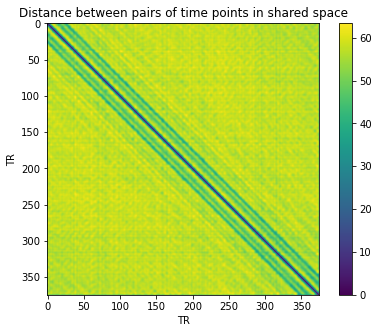

In [54]:
dist_mat = sp_distance.squareform(sp_distance.pdist(srm.s_.T))
plt.figure(figsize=(7,5))
plt.title('Distance between pairs of time points in shared space')
plt.xlabel('TR')
plt.ylabel('TR')
plt.imshow(dist_mat, cmap='viridis')
plt.colorbar()

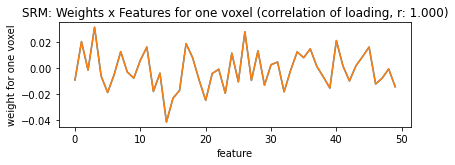

In [62]:
plt.subplot(211)

plt.plot(srm.w_[0][0,:])
plt.plot(srm.w_[1][0,:])
feature_corr = np.corrcoef(srm.w_[0][0,:], srm.w_[1][0,:].T)[0,1]
plt.title('SRM: Weights x Features for one voxel (correlation of loading, r: %0.3f)' % feature_corr) 
plt.xlabel('feature')
plt.ylabel('weight for one voxel')
plt.tight_layout()

In [63]:
# Transform the SRM data into shared space
shared_train = srm.transform(train_data)

# Zscore the transformed training data
for subject in range(0, all_data.shape[2]):
    shared_train[subject] = stats.zscore(shared_train[subject], axis=1, ddof=1)

In [64]:
# Reorganize the data back into an appropriate space for ISC
raw_obj = np.zeros((train_data[0].shape[0], train_data[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    raw_obj[:, :, ppt] = train_data[ppt]
    
# Perform ISC on all participants, collapsing across participants    
corr_raw = isc(raw_obj, summary_statistic='mean')
corr_raw = np.nan_to_num(corr_raw)  

# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_train[0].shape[0], shared_train[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    shared_obj[:, :, ppt] = shared_train[ppt]
    
# Perform ISC on all participants, collapsing across participants        
corr_shared = isc(shared_obj, summary_statistic='mean')
corr_shared = np.nan_to_num(corr_shared)

Independent samples t test between raw and SRM transformed data: 958.07117195227 p: 0.0


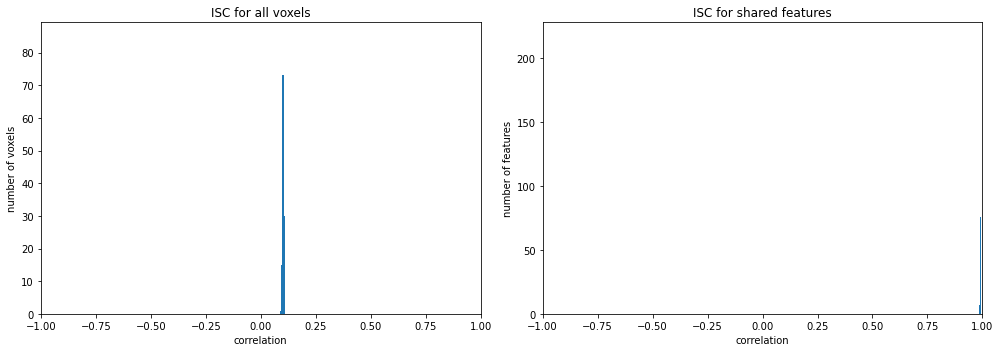

In [65]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('ISC for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('ISC for shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1])

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

In [88]:
# Transform the test data into the shared space using the individual weight matrices
shared_test = srm.transform(test_data)

# Zscore the transformed test data
for subject in range(0, all_data.shape[2]):
    shared_test[subject] = stats.zscore(shared_test[subject], axis=1, ddof=1)